Assembling Downloaded Game Statistics
===

In [10]:
import numpy as np
import goldsberry
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
pd.set_option("display.max_columns",50) # Change Pandas Display Options
%matplotlib inline
goldsberry.__version__

'1.0.1'

In [11]:
SEASON_LIST = list(reversed(['2016-17','2015-16','2014-15','2013-14','2012-13']))
###
### IMPORTANT - truncate to test while data is downloading
###

In [12]:
def get_games(season):
    '''Downloads and returns as a DataFrame a set of games and basic stats for a specified season.'''
    gameids = goldsberry.GameIDs(Season=season)
    gameids = pd.DataFrame(gameids.game_list())
    return gameids

def create_stats_table(game_list):
    '''Create Statistics table
       Creates a lookup table for all the teams' cumulative stats for every date.'''
    gameids_srt = game_list.sort_values(by='GAME_DATE')
    gameids_srt['GAME_COUNT'] = 1

    all_stats = gameids_srt.groupby(['TEAM_ID','GAME_DATE','GAME_ID']).sum().groupby(level=[0]).cumsum()
    # Add GAME_ID as a column instead of an index
    all_stats.loc[(slice(None),slice(None))].reset_index(level='GAME_ID',inplace=True)
    return all_stats

def calculate_stats(stats_df, stats_type='basic'):
    '''Calculate the statistics after DataFrame has been created
       Indexed by (Team ID, Date (as a datetime object), Game_id)'''
    if stats_type=='basic':
        pct_columns = ['FG','FG3','FT']  # ==> Total Made/Total Attempted 
        avg_columns = ['AST','BLK','DREB','OREB','PF','REB','STL','TOV','FGA',"FGM",'FG3A',"FG3M",'FTA','FTM','PLUS_MINUS'] # ==> Moving Average for game n (Game 1->Game 1-n)
    elif stats_type=='advanced':
        pct_columns = []
        avg_columns = ['OFF_RATING','DEF_RATING','NET_RATING','AST_PCT','AST_TOV','AST_RATIO','OREB_PCT','DREB_PCT','REB_PCT','TM_TOV_PCT',
             'TS_PCT','EFG_PCT','PACE','PIE','USG_PCT']
    elif stats_type=='misc':
        # Put pct_columns or avg_columns for the given stats table here.
        # Just need to hard-code.
        pct_columns = []
        avg_columns = [u'BLK', u'BLKA', u'OPP_PTS_2ND_CHANCE',
                       u'OPP_PTS_FB', u'OPP_PTS_OFF_TOV', u'OPP_PTS_PAINT', u'PF', u'PFD',
                       u'PTS_2ND_CHANCE', u'PTS_FB', u'PTS_OFF_TOV', u'PTS_PAINT']
    elif stats_type=='scoring':
        pct_columns = []
        avg_columns = [u'PCT_AST_2PM', u'PCT_AST_3PM', u'PCT_AST_FGM',
                       u'PCT_FGA_2PT', u'PCT_FGA_3PT', u'PCT_PTS_2PT', u'PCT_PTS_2PT_MR',
                       u'PCT_PTS_3PT', u'PCT_PTS_FB', u'PCT_PTS_FT', u'PCT_PTS_OFF_TOV',
                       u'PCT_PTS_PAINT', u'PCT_UAST_2PM', u'PCT_UAST_3PM', u'PCT_UAST_FGM']
        
    elif stats_type=='fourfactors':
        pct_columns = []
        avg_columns = [u'FTA_RATE', u'OPP_EFG_PCT', u'OPP_FTA_RATE', u'OPP_OREB_PCT', 
                       u'OPP_TOV_PCT',u'TM_TOV_PCT']
    
    team_abbrvs = stats_df.index.levels[0]

    # Loop over all teams
    for team in team_abbrvs:
        for col in avg_columns: # running average
            stats_df.loc[(team, slice(None)),col+'_mean'] = stats_df.loc[(team, slice(None)),col].shift(1) / stats_df.loc[(team, slice(None)),'GAME_COUNT'].shift(1)
        for col in pct_columns: # made/attempted
            stats_df.loc[(team, slice(None)),col+'_pct'] = stats_df.loc[(team, slice(None)), col+'M'].shift(1) / stats_df.loc[(team, slice(None)), col+'A'].shift(1)
    
    return stats_df

In [19]:
# RUN THIS TO GENERATE FINAL TABLE
# For each season, join each data table based on TEAM_ID and GAME_ID
# after calculating statistics based on TEAM_ID and GAME_DATE.

final_seasons = {}

for season in SEASON_LIST:
    print "processing season {}...".format(season)
    # Download a set of games
    games = get_games(season)
    # Make GAME_ID an integer for consistency
    games['GAME_ID'] = games['GAME_ID'].astype(int)
    # Create stats lookup table
    stats_tbl = create_stats_table(games)
    stats_tbl = calculate_stats(stats_tbl, stats_type='basic').reset_index(level=['TEAM_ID','GAME_DATE'])
    
    joined_data = games.set_index(['TEAM_ID','GAME_ID']).join(stats_tbl.set_index(['TEAM_ID','GAME_ID']),
                                                                        lsuffix='',rsuffix='_R')
    joined_data.reset_index(inplace=True)
    for stats_type in ('advanced','fourfactors','misc','scoring'):
        #print "processing {} {}".format(stats_type, season)
        # load in the data
        games_stats = pd.read_csv('{}_{}.csv'.format(stats_type.title(), season))
        # append a game_date column to game_id
        id_to_date = pd.Series(games['GAME_DATE'].values, index=games['GAME_ID']).to_dict()
        games_stats['GAME_DATE'] = games_stats['GAME_ID'].map(id_to_date)
        
        curr_stats_tbl = create_stats_table(games_stats)
        
        curr_stats_tbl = calculate_stats(curr_stats_tbl, stats_type=stats_type).reset_index(level=['TEAM_ID','GAME_DATE'])
        
        joined_data = joined_data.set_index(['TEAM_ID','GAME_ID']).join(curr_stats_tbl.set_index(['TEAM_ID','GAME_ID']),
                                                                                  lsuffix='',rsuffix='_R')
        joined_data.reset_index(inplace=True)
    
    # Add target columns from the original game list
    del joined_data['PLUS_MINUS']
    target = games.set_index(['TEAM_ID','GAME_ID'])['PLUS_MINUS']
    
    joined_data = joined_data.set_index(['TEAM_ID','GAME_ID']).join(target, lsuffix='', rsuffix='_TARGET').reset_index()
    
    final_seasons[season] = joined_data
    print "done with season {}".format(season)
# All done!
print "done!"

processing season 2012-13...
done with season 2012-13
processing season 2013-14...
done with season 2013-14
processing season 2014-15...
done with season 2014-15
processing season 2015-16...
done with season 2015-16
processing season 2016-17...
done with season 2016-17
done!


In [20]:
final_games = {}

for season in SEASON_LIST:
    print "processing season {}".format(season)
    # Create a new dataframe with home team and away team stats
    final_df = pd.DataFrame(columns=[colname+'_HOME' for colname in joined_data.columns] + \
                                    [colname+'_AWAY' for colname in joined_data.columns],
                            index=joined_data['GAME_ID'].unique())
    home_cols = [colname+'_HOME' for colname in joined_data.columns]
    away_cols = [colname+'_AWAY' for colname in joined_data.columns]

    for i, gid in enumerate(joined_data['GAME_ID'].unique()):
        # first, find home team
        if i % (joined_data.shape[0]/(2*4)) == 0:
            print '{:.1f}%'.format(2*100*float(i)/joined_data.shape[0])
        
        home_data = joined_data[(joined_data['GAME_ID']==gid) & (joined_data['MATCHUP'].str.contains('vs.'))].copy()
        home_data.columns = home_cols
        #print home_data.head()
        away_data = joined_data[(joined_data['GAME_ID']==gid) & (joined_data['MATCHUP'].str.contains('@'))].copy()
        away_data.columns = away_cols
        
        final_df.ix[gid, home_cols] = home_data[home_cols].values
        final_df.ix[gid, away_cols] = away_data[away_cols].values
    
    # Tidying up
    final_df.index.name = 'GAME_ID'
    final_games[season] = final_df
    
print "done!"

processing season 2012-13
0.0%
25.0%
49.9%
74.9%
99.8%
processing season 2013-14
0.0%
25.0%
49.9%
74.9%
99.8%
processing season 2014-15
0.0%
25.0%
49.9%
74.9%
99.8%
processing season 2015-16
0.0%
25.0%
49.9%
74.9%
99.8%
processing season 2016-17
0.0%
25.0%
49.9%
74.9%
99.8%
done!


### Looking at the data
Now that everything is loaded into the `final_games` dict, let's peek inside.

In [15]:
print "Seasons available: ", ' '.join(final_games.keys())
print "shape 2012-13:", final_games['2012-13'].shape
final_games['2012-13'].head()

Seasons available:  2015-16 2012-13 2016-17 2013-14 2014-15
shape 2012-13: (1230, 352)


,TEAM_ID_HOME,GAME_ID_HOME,AST_HOME,BLK_HOME,DREB_HOME,FG3A_HOME,FG3M_HOME,FG3_PCT_HOME,FGA_HOME,FGM_HOME,FG_PCT_HOME,FTA_HOME,FTM_HOME,FT_PCT_HOME,GAME_DATE_HOME,MATCHUP_HOME,MIN_HOME,OREB_HOME,PF_HOME,PLUS_MINUS_HOME,PTS_HOME,REB_HOME,SEASON_ID_HOME,STL_HOME,TEAM_ABBREVIATION_HOME,...,PCT_PTS_2PT_AWAY,PCT_PTS_2PT_MR_AWAY,PCT_PTS_3PT_AWAY,PCT_PTS_FB_AWAY,PCT_PTS_FT_AWAY,PCT_PTS_OFF_TOV_AWAY,PCT_PTS_PAINT_AWAY,PCT_UAST_2PM_AWAY,PCT_UAST_3PM_AWAY,PCT_UAST_FGM_AWAY,PCT_AST_2PM_mean_AWAY,PCT_AST_3PM_mean_AWAY,PCT_AST_FGM_mean_AWAY,PCT_FGA_2PT_mean_AWAY,PCT_FGA_3PT_mean_AWAY,PCT_PTS_2PT_mean_AWAY,PCT_PTS_2PT_MR_mean_AWAY,PCT_PTS_3PT_mean_AWAY,PCT_PTS_FB_mean_AWAY,PCT_PTS_FT_mean_AWAY,PCT_PTS_OFF_TOV_mean_AWAY,PCT_PTS_PAINT_mean_AWAY,PCT_UAST_2PM_mean_AWAY,PCT_UAST_3PM_mean_AWAY,PCT_UAST_FGM_mean_AWAY
GAME_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21600707,1610612744,21600707,35,7,39,34,17,0.5,92,57,0.62,16,13,0.813,2017-01-28,GSW vs. LAC,240,9,17,46,144,48,22016,9,GSW,...,25.706,8.154,13.807,5.565,8.483,6.969,17.554,24.311,9.999,20.628,0.490745,0.792596,0.568191,0.67334,0.32666,0.536511,0.170447,0.285957,0.117106,0.177447,0.145021,0.366106,0.509277,0.207426,0.431809
21600919,1610612755,21600919,30,2,30,34,14,0.412,88,43,0.489,7,6,0.857,2017-03-04,PHI vs. DET,240,6,18,-30,106,36,22016,5,PHI,...,39.245,13.018,14.005,7.481,8.744,8.993,26.234,33.493,11.333,29.057,0.459902,0.820787,0.532213,0.735344,0.264656,0.632754,0.210033,0.225967,0.118656,0.14118,0.14441,0.422836,0.540131,0.17923,0.467836
21600800,1610612752,21600800,36,5,23,38,16,0.421,93,52,0.559,5,3,0.6,2017-02-10,NYK vs. DEN,240,10,14,-8,123,33,22016,10,NYK,...,29.279,5.611,14.393,6.989,9.321,6.391,23.662,25.999,6.379,21.003,0.511173,0.879731,0.604654,0.687942,0.312115,0.551904,0.106731,0.26975,0.133808,0.178231,0.120404,0.445058,0.488846,0.120269,0.395365
21600559,1610612757,21600559,36,5,35,35,15,0.429,98,51,0.52,12,7,0.583,2017-01-08,POR vs. DET,290,7,11,-1,124,42,22016,5,POR,...,24.551,7.985,8.856,4.624,5.588,5.47,16.568,20.616,5.7,17.727,0.476368,0.856605,0.550632,0.737474,0.262526,0.626711,0.204658,0.228,0.118947,0.145158,0.138053,0.422105,0.523658,0.143421,0.449447
21600355,1610612746,21600355,34,2,31,36,17,0.472,94,54,0.574,9,8,0.889,2016-12-10,LAC vs. NOP,240,9,22,28,133,40,22016,10,LAC,...,14.346,4.247,5.485,3.181,4.171,3.304,10.1,11.53,3.602,9.855,0.517739,0.848826,0.58787,0.714217,0.285826,0.597217,0.172217,0.228522,0.135,0.174304,0.142,0.425043,0.482261,0.151174,0.412174


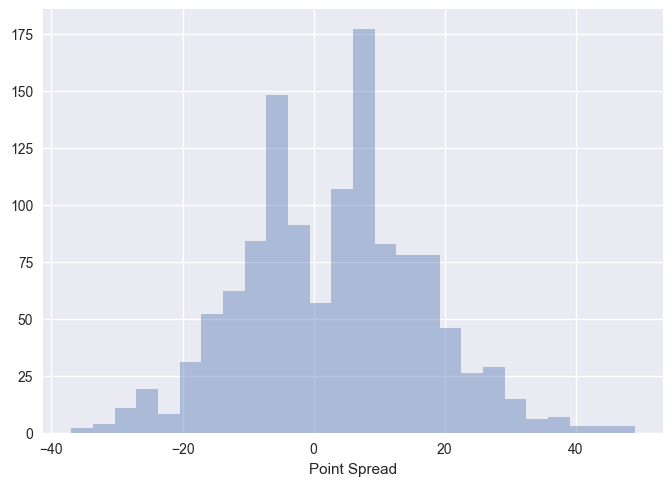

In [9]:
import seaborn as sns
sns.distplot(final_games['2012-13']['PLUS_MINUS_HOME'], norm_hist=False, kde=False)
plt.xlabel('Point Spread')

In [24]:
output = pd.DataFrame()
for season, df in final_games.iteritems():
    output = pd.concat([output, df])
    
output.shape

(6150, 352)

In [25]:
output.to_csv('final.csv')

In [30]:
# Get rid of redundant columns
# Construct all the features we want
cols_to_keep = ['GAME_DATE_HOME','MATCHUP_HOME','PLUS_MINUS_HOME','PLUS_MINUS_AWAY']
cols_to_keep += [c for c in output.columns if 'TEAM' in c \
               or 'mean' in c or 'pct' in c]
# Keep the tabulated statistics

output_clean = output[cols_to_keep]
output_clean.to_csv('final_clean.csv')